In [20]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
import os
import glob
import gc
gc.collect()

1572

In [21]:
# load and save functions
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name , 'rb') as f:
        return pd.DataFrame(pickle.load(f))

def read_data(locationSpectra):
    filenames = glob.glob(locationSpectra+'*pkl')
    
    cut_off = 5000
    X = np.zeros((4900,cut_off,2))
    #wavelength = np.zeros((len(filenames),cut_off))
    X_scaled = np.zeros((4900,cut_off,2))
    y = []
    sc = MinMaxScaler()
    counter_excluded = 0
    for i in range(4900):
        df_current = load_obj(filenames[i])
        l = len(df_current['model'])
        
        wavelength = np.power(10,df_current['loglam'][0:l])
        flux = df_current['model'][0:l]
        flux_scaled = np.array(sc.fit_transform(np.array(flux).reshape(-1,1))).reshape(len(flux))
        
        X[i][0:l] = np.stack((wavelength,flux),axis=1)
        
        # Scale result in new array
        X_scaled[i][0:l] = np.stack((wavelength,flux_scaled),axis=1)
        
        y.append(df_current['information'].iloc[0])
    X = X[0:(len(X)-counter_excluded)]
    X = np.array(X)
    wavelength = wavelength[0:(len(X)-counter_excluded)]
    y = np.array(y)
    
    return X,y,X_scaled

In [22]:
locationSpectra = 'spectra_matched_multiproc/'
_,y,X = read_data(locationSpectra)

In [23]:
def paralellised_append(elem_X,min_X,step):
    """
    elem_X = varyingData
    [min_X,step] = constantData
    """
    elem_X_new = [[] for i in range(n_nodes)]
    for j in range(elem_X.shape[0]):
        if(elem_X[j,0]>0):
            elem_X_new[int((elem_X[j,0] - min_X) / step)].append(elem_X[j,1])
    return elem_X_new

def paralellised_assign(elem_X_new):
    for j in range(elem_X_new.shape[0]):
        elem_X_new[j] = np.array(elem_X_new[j])
        if(elem_X_new[j].size > 0):
            elem_X_new[j] = np.mean(np.array(elem_X_new[j]))
        else:
            elem_X_new[j] = 0.
    return elem_X_new

def prepare_cnn_entries(X,n_nodes=100):
    """
    This function transforms the wavelength input to a discrete input so that
    it can be fed to the CNN.
    """
    idx = X[:,:,0] > 0
    X_nozeros = X[idx]
    min_X = np.min(X_nozeros[:,0])
    max_X = np.max(X_nozeros[:,0])
    del X_nozeros
    gc.collect()  

    
    
    wavelength_new,step = np.linspace(min_X,max_X, num=n_nodes,retstep=True)
    #wavelength_edges = np.histogram_bin_edges(wavelength_all,bins=n_nodes)

    X_new = [[[] for i in range(n_nodes)] for j in range(X.shape[0])]
    
    
    print('Start converting to discrete wavelength inputs...')    
    for i in range(X.shape[0]):
        if(i % int(X.shape[0] / 10) == 0):
            print('Part 1.... ' + str(round(100*i/X.shape[0],0)) + ' % completed')
        X_new[i] = paralellised_append(X[i],min_X,step)
    
    #del X
    gc.collect()
    
    X_new = np.array(X_new)
    print(np.count_nonzero(X_new))
    
    for i in range(X_new.shape[0]):
        if(i % int(X_new.shape[0] / 10) == 0):
            print('Part 2.... ' + str(round(100*i/X_new.shape[0])) + ' % completed')
        X_new[i] = paralellised_assign(X_new[i])
            
    print(np.count_nonzero(X_new))
    
    return X_new,wavelength_new



In [24]:
n_nodes = 100
X,wavelength = prepare_cnn_entries(X,n_nodes)

Start converting to discrete wavelength inputs...
Part 1.... 0.0 % completed
Part 1.... 10.0 % completed
Part 1.... 20.0 % completed
Part 1.... 30.0 % completed
Part 1.... 40.0 % completed
Part 1.... 50.0 % completed
Part 1.... 60.0 % completed
Part 1.... 70.0 % completed
Part 1.... 80.0 % completed
Part 1.... 90.0 % completed
445528
Part 2.... 0 % completed
Part 2.... 10 % completed
Part 2.... 20 % completed
Part 2.... 30 % completed
Part 2.... 40 % completed
Part 2.... 50 % completed
Part 2.... 60 % completed
Part 2.... 70 % completed
Part 2.... 80 % completed
Part 2.... 90 % completed
445524


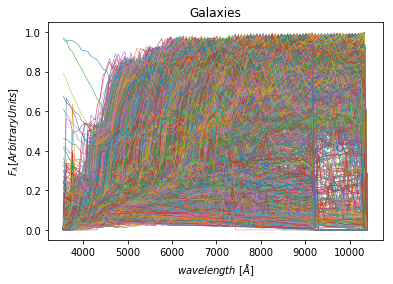

In [25]:
# plot galaxies
idx_galaxy = (y == 'GALAXY')
X_galaxy = X[idx_galaxy]

fig = plt.figure()
for i in range(len(X_galaxy)):
    try:
        plt.plot(wavelength,X_galaxy[i],linewidth=0.5)
    except:
        pass
        
#plt.xlim(min(wavelength_galaxy),max(wavelength_galaxy))
plt.xlabel(r'$wavelength$ '+r'$[\AA]$')
#plt.ylabel(r'$F_\lambda$ '+r'$[erg*cm^{-2}*s^{-1}*\AA^{-1}]$')
plt.ylabel(r'$F_\lambda$'+r'$[Arbitrary Units]$')
plt.title('Galaxies')
plt.savefig('spec_plots_preproc/galaxies_model_BOSS.png')
plt.show()

In [26]:
plt.close()

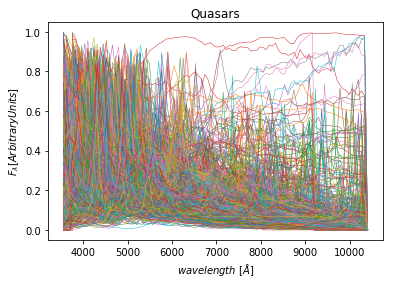

In [27]:
# plot Quasars
idx_qso = (y == 'QSO   ')
X_qso = X[idx_qso]

fig = plt.figure()
for i in range(len(X_qso)):
    try:
        plt.plot(wavelength,X_qso[i],linewidth=0.5)
    except:
        pass
        
#plt.xlim(min(wavelength_galaxy),max(wavelength_galaxy))
plt.xlabel(r'$wavelength$ '+r'$[\AA]$')
#plt.ylabel(r'$F_\lambda$ '+r'$[erg*cm^{-2}*s^{-1}*\AA^{-1}]$')
plt.ylabel(r'$F_\lambda$'+r'$[Arbitrary Units]$')
plt.title('Quasars')
plt.savefig('spec_plots_preproc/quasars_model_BOSS.png')
plt.show()

In [28]:
plt.close()

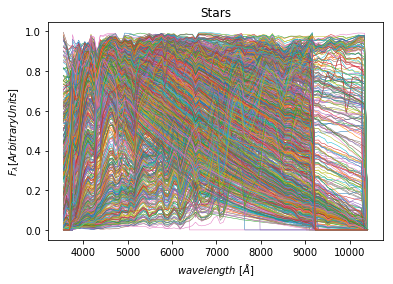

In [29]:
# plot galaxies
idx_star = (y == 'STAR  ')
X_star = X[idx_star]

fig = plt.figure()
for i in range(len(X_star)):
    try:
        plt.plot(wavelength,X_star[i],linewidth=0.5)
    except:
        pass
        
#plt.xlim(min(wavelength_galaxy),max(wavelength_galaxy))
plt.xlabel(r'$wavelength$ '+r'$[\AA]$')
#plt.ylabel(r'$F_\lambda$ '+r'$[erg*cm^{-2}*s^{-1}*\AA^{-1}]$')
plt.ylabel(r'$F_\lambda$'+r'$[Arbitrary Units]$')
plt.title('Stars')
plt.savefig('spec_plots_preproc/stars_model_BOSS.png')
plt.show()